## fakeNews Classifier using LSTM


In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('fake-news/train.csv')

In [3]:
df.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
###Drop Nan Values
df=df.dropna()

In [5]:
## Get the Independent Features

X=df.drop('label',axis=1)

In [6]:
## Get the Dependent features
y=df['label']

In [7]:
X.shape

(18285, 4)

In [8]:
y.shape

(18285,)

In [9]:
import tensorflow as tf

In [10]:
tf.__version__

'2.8.0'

In [11]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

## Onehot Representation


In [12]:
messages=X.copy()

In [13]:
### Vocabulary size
voc_size=5000

In [14]:
messages.reset_index(inplace=True)

In [15]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MYPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def preprocessing(messages):
    corpus = []
    for i in range(0, len(messages)):
        review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

In [17]:
corpus=preprocessing(messages)
print(corpus[1])

flynn hillari clinton big woman campu breitbart


In [18]:
# onehot_repr=[one_hot(words,voc_size)for words in corpus] 
# onehot_repr
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 13932


## Embedding Representation


In [19]:
sent_length=20
embedded_docs=pad_sequences(tokenizer.texts_to_sequences(corpus),padding='pre',maxlen=sent_length)
print(embedded_docs)


[[   0    0    0 ... 1775 3009  420]
 [   0    0    0 ...  150 1090    5]
 [   0    0    0 ...  856   33   83]
 ...
 [   0    0    0 ...    1    3    2]
 [   0    0    0 ... 4196 2465 5024]
 [   0    0    0 ...  197  137 1455]]


In [20]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
len(embedded_docs),y.shape

(18285, (18285,))

In [22]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [23]:
X_final.shape,y_final.shape

((18285, 20), (18285,))

In [24]:
y_final=y_final.reshape(-1,1)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12250, 20)
(6035, 20)
(12250, 1)
(6035, 1)


In [27]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)

Epoch 1/10
383/383 [==============================] - 8s 16ms/step - loss: 0.2779 - accuracy: 0.8760 - val_loss: 0.1808 - val_accuracy: 0.9239
Epoch 2/10
383/383 [==============================] - 6s 15ms/step - loss: 0.1120 - accuracy: 0.9584 - val_loss: 0.1885 - val_accuracy: 0.9239
Epoch 3/10
383/383 [==============================] - 6s 15ms/step - loss: 0.0617 - accuracy: 0.9785 - val_loss: 0.2355 - val_accuracy: 0.9233
Epoch 4/10
383/383 [==============================] - 6s 15ms/step - loss: 0.0361 - accuracy: 0.9879 - val_loss: 0.2903 - val_accuracy: 0.9238
Epoch 5/10
383/383 [==============================] - 6s 15ms/step - loss: 0.0224 - accuracy: 0.9938 - val_loss: 0.3298 - val_accuracy: 0.9188
Epoch 6/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0145 - accuracy: 0.9960 - val_loss: 0.4026 - val_accuracy: 0.9208
Epoch 7/10
383/383 [==============================] - 6s 15ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.3964 - val_accuracy: 0.9155

In [28]:
y_pred=np.round(model.predict(X_test))


In [29]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(y_test,y_pred))
confusion_matrix=confusion_matrix(y_test,y_pred)

0.9143330571665286


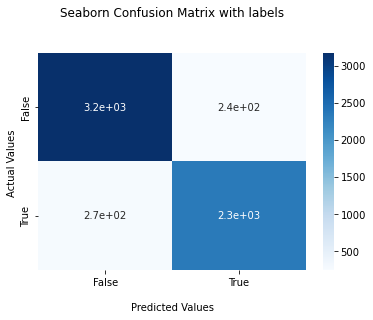

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Testing the model with user defined input

In [31]:
def preprocess(x):
    x1=[]
    review=re.sub('[^a-zA-Z]', ' ', x)
    
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    x1.append(review)
    result=pad_sequences(tokenizer.texts_to_sequences(x1),padding='pre',maxlen=sent_length)
    result=np.array(result)
    return result

In [32]:
print('Enter the News ')

x= input()
print('----------------------------------------')
result=preprocess(x)
xt=np.round(model.predict(result))
if(xt==1):
    print('News is Fake beware of it')
else:
    print('News is not Fake ')

Enter the News 
stock market will crash
----------------------------------------
News is Fake beware of it
